# Section 3 - Audio Phishing Detection (vishing)

## 3 Introduction

**strategy**

**1**. We plan to use Whisper base/medium models for model training purposes. For the website, we will use the Whisper API (which is paid) for real-time audio transcription.


**2**. The Whisper API returns transcribed text in JSON format like this:

   **{**
   
   **"text": "This is the transcribed audio text."**
   
   **}**

   We will extract this text and pass it to RoBERTa for phishing detection.
   

**3**. For dataset generation, we are searching for existing audio transcriptions and also converting audio to text using the free Whisper base model. Additionally, we plan to create our own transcripts. Once we gather enough data and fine-tune RoBERTa, we will move to the final integration phase.

## 3.1 References

1. /kaggle/input/audio-dataset-1-robocall-dataset


https://github.com/wspr-ncsu/robocall-audio-dataset.git

**About Dataset**

**Data Collection:** The audio recordings come from honeypots and voicemails in various formats like WAV, AMR, and MP3.

**Audio Processing:** All recordings were converted to WAV format and resampled to 16kHz using ffmpeg for consistency.

**Stereo to Mono Conversion:** For stereo recordings:

*     The _left.wav file contains the robocaller’s audio, which was used for transcription.
*     Te _right.wav file contains the local party’s audio (honeypot/voicemail) and is included for completeness.

**Metadata Details:** The metadata.csv file includes:

*     Audio filenames, transcriptions, and the detected language (96.2% in English, 3.8% in Mandarin/Chinese), transcribed using Whisper.

**Cease and Desist Letters**: Each audio file is linked to its corresponding cease and desist or warning letter, available in the pdf_files directory.

## 3.2 Audio to Text

**Setting up Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# pip install openai-whisper

In [ ]:
# import whisper


# model = whisper.load_model("base")


# audio_file = "/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/1031590_normalized.wav"
# result = model.transcribe(audio_file)


# print("Transcribed Text:\n")
# print(result["text"])

## 3.3 Phishing Dataset collection

**Dataset 1**

In [ ]:
vdf = pd.read_csv('metadata.csv')

vdf.head()

,file_name,language,transcript,case_details,case_pdf
0,audio-wav-16khz/1112259_normalized.wav,en,We would like to inform you that there is an o...,cease-desist-letter-every1-telecom,pdf_files/pointofnoentry-every1telecomceasedes...
1,audio-wav-16khz/58345_normalized.wav,en,to connect with Apple Support Advisor. Press 2...,cease-desist-letter-peerless-network-inc,pdf_files/pointofnoentry-peerlessceasedesistle...
2,audio-wav-16khz/936704_normalized.wav,en,Hello. This call is to inform you that a pre-a...,cease-desist-letter-one-eye-llc,pdf_files/pointofnoentry-oneeyecdletter.pdf
3,audio-wav-16khz/1100696_normalized.wav,en,"one to start your claim. Otherwise, press 2 to...",cease-desist-letter-business-telecommunication...,pdf_files/pointofnoentry-businesstelecomceased...
4,audio-wav-16khz/807777_normalized.wav,en,Thank you for choosing Hilton Hotels. We would...,cease-desist-letter-hfa-services-llc-also-dba-...,pdf_files/pointofnoentry-hfaservsceasedesistle...


In [ ]:
# cleaning cvs file
vdf = vdf[['file_name', 'transcript']]
vdf.head()

,file_name,transcript
0,audio-wav-16khz/1112259_normalized.wav,We would like to inform you that there is an o...
1,audio-wav-16khz/58345_normalized.wav,to connect with Apple Support Advisor. Press 2...
2,audio-wav-16khz/936704_normalized.wav,Hello. This call is to inform you that a pre-a...
3,audio-wav-16khz/1100696_normalized.wav,"one to start your claim. Otherwise, press 2 to..."
4,audio-wav-16khz/807777_normalized.wav,Thank you for choosing Hilton Hotels. We would...


In [ ]:
vdf = vdf[['transcript']].rename(columns={'transcript': 'text'})

vdf['label'] = 1

vdf = vdf[['label','text']]

vdf.to_csv('modified_dataset.csv', index=False)

vdf.head()

,label,text
0,1,We would like to inform you that there is an o...
1,1,to connect with Apple Support Advisor. Press 2...
2,1,Hello. This call is to inform you that a pre-a...
3,1,"one to start your claim. Otherwise, press 2 to..."
4,1,Thank you for choosing Hilton Hotels. We would...


In [ ]:
vdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1432 non-null   int64 
 1   text    1432 non-null   object
dtypes: int64(1), object(1)
memory usage: 22.5+ KB


**Dataset 2**

In [ ]:
vdf2 = pd.read_csv("28_000_Detailed_Phishing_Conversations_Dataset.csv")

vdf2.head()

,phishing_message,response
0,Limited-time offer: Act now to claim your excl...,I don't remember signing up for this service. ...
1,Your subscription will expire soon. Renew now ...,This seems like a scam. I'm not comfortable sh...
2,Immediate action required! Your account will b...,I'm not sure if this is legitimate. Can you gi...
3,Immediate action required! Your account will b...,I'm not sure if this is legitimate. Can you gi...
4,Limited-time offer: Act now to claim your excl...,I don't remember signing up for this service. ...


In [ ]:
vdf2 = vdf2[['phishing_message']].rename(columns={'phishing_message': 'text'})

vdf2['label'] = 1

vdf2 = vdf2[['label','text']]

vdf2.to_csv('modified_dataset4.csv', index=False)

vdf2.head()

,label,text
0,1,Limited-time offer: Act now to claim your excl...
1,1,Your subscription will expire soon. Renew now ...
2,1,Immediate action required! Your account will b...
3,1,Immediate action required! Your account will b...
4,1,Limited-time offer: Act now to claim your excl...


In [ ]:
vdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   28000 non-null  int64 
 1   text    28000 non-null  object
dtypes: int64(1), object(1)
memory usage: 437.6+ KB


## 3.4 Safe Dataset collection

**Dataset 1**

In [ ]:
safe1v1 = pd.read_csv('Conversation.csv')

safe1v1.head()

,Unnamed: 0,question,answer
0,0,"hi, how are you doing?",i'm fine. how about yourself?
1,1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,3,no problem. so how have you been?,i've been great. what about you?
4,4,i've been great. what about you?,i've been good. i'm in school right now.


In [ ]:
safe1v1 = safe1v1[['question', 'answer']].rename(columns={'question': 'left', 'answer': 'right'})

safe1v1 = safe1v1[['left', 'right']]

safe1v1.head()

,left,right
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [ ]:
safe1v1 = safe1v1.dropna()
print(safe1v1.isna().sum())

left     0
right    0
dtype: int64


In [ ]:
safe1v1.duplicated().sum()

np.int64(1)

In [ ]:
safe1v1 = safe1v1.drop_duplicates(keep='first')
safe1v1.duplicated().sum()

np.int64(0)

In [ ]:
safe1v1['text'] = safe1v1['left'] + ' ' + safe1v1['right']


safe1v2 = safe1v1[['text']].copy()

safe1v2 = safe1v2.reset_index(drop=True)


print(safe1v2)

                                                   text
0     hi, how are you doing? i'm fine. how about you...
1     i'm fine. how about yourself? i'm pretty good....
2     i'm pretty good. thanks for asking. no problem...
3     no problem. so how have you been? i've been gr...
4     i've been great. what about you? i've been goo...
...                                                 ...
3719  that's a good question. maybe it's not old age...
3720            are you right-handed? yes. all my life.
3721  yes. all my life. you're wearing out your righ...
3722  you're wearing out your right hand. stop using...
3723  but i do all my writing with my right hand. st...

[3724 rows x 1 columns]


In [ ]:
safe1v2['label'] = 0

safe1v3 = safe1v2[['label','text']]

safe1v3.to_csv('modified_dataset.csv', index=False)

safe1v3.head()

,label,text
0,0,"hi, how are you doing? i'm fine. how about you..."
1,0,i'm fine. how about yourself? i'm pretty good....
2,0,i'm pretty good. thanks for asking. no problem...
3,0,no problem. so how have you been? i've been gr...
4,0,i've been great. what about you? i've been goo...


In [ ]:
safe1v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3724 entries, 0 to 3723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3724 non-null   int64 
 1   text    3724 non-null   object
dtypes: int64(1), object(1)
memory usage: 58.3+ KB


**Dataset 2**

In [ ]:
safe_df2 = pd.read_csv("line_index_all.csv")

safe_df2.head()

,EN1223,wef_12484_01482829612,The sun provides energy
0,BI0113,wef_12484_01345932698,Zoe invited you to an event
1,EN0971,wef_12484_00999757777,This is the cinematic superhero showdown you'...
2,EN0026,wef_12484_00036278823,That quick beige fox jumped in the air over e...
3,EN1472,wef_12484_00458512623,The song was accompanied by two music videos ...
4,EN0005,wef_12484_00445516961,People look but no one ever finds it


In [ ]:
print(safe_df2.columns)


Index(['EN1223', ' wef_12484_01482829612', ' The sun provides energy'], dtype='object')


In [ ]:
# Strip any leading or trailing spaces in the column names
safe_df2.columns = safe_df2.columns.str.strip()

# Now adjust the code to reference the correct column name
safe_df2 = safe_df2[['The sun provides energy']].rename(columns={'The sun provides energy': 'text'})

# Add a label column with the value of 1
safe_df2['label'] = 0

# Reorder the columns
safe_df2 = safe_df2[['label', 'text']]

# Save the modified DataFrame to a CSV file
safe_df2.to_csv('modified_dataset3.csv', index=False)


In [ ]:
safe_df2.head(5)

,label,text
0,0,Zoe invited you to an event
1,0,This is the cinematic superhero showdown you'...
2,0,That quick beige fox jumped in the air over e...
3,0,The song was accompanied by two music videos ...
4,0,People look but no one ever finds it


In [ ]:
safe_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17876 entries, 0 to 17875
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   17876 non-null  int64 
 1   text    17876 non-null  object
dtypes: int64(1), object(1)
memory usage: 279.4+ KB


**Dataset 3**

In [ ]:
safe_df3 = pd.read_csv('10_000_Safe_Conversations_Dataset.csv')

safe_df3.head()

,conversation_start,response
0,"Hello, did you catch the game last night?","Yeah, it's been a while! Good to see you."
1,Good evening! Any weekend plans?,"I've been busy with work, but all is good."
2,Good evening! Any weekend plans?,"My day has been pretty good, how about yours?"
3,Good evening! Any weekend plans?,"Not much, just relaxing. How about you?"
4,"Hi, how are you?","Not yet, I'm still deciding what to do."


In [ ]:
safe_df3 = safe_df3.dropna()
print(safe_df3.isna().sum())

conversation_start    0
response              0
dtype: int64


In [ ]:
safe_df3['text'] = safe_df3['conversation_start'] + ' ' + safe_df3['response']


safe_df3 = safe_df3[['text']].copy()

safe_df3 = safe_df3.reset_index(drop=True)


print(safe_df3)

                                                   text
0     Hello, did you catch the game last night? Yeah...
1     Good evening! Any weekend plans? I've been bus...
2     Good evening! Any weekend plans? My day has be...
3     Good evening! Any weekend plans? Not much, jus...
4     Hi, how are you? Not yet, I'm still deciding w...
...                                                 ...
9995  Hi, how's the weather over there? It's sunny a...
9996  Hi, what's new with you? I'm doing great, than...
9997  Good evening! Any weekend plans? Yeah, it's be...
9998  Hi, how's work going? Not yet, I'm still decid...
9999  Hey, what have you been up to? Not yet, I'm st...

[10000 rows x 1 columns]


In [ ]:
safe_df3['label'] = 0

safe_df3 = safe_df3[['label','text']]

safe_df3.to_csv('modified_dataset2.csv', index=False)

safe_df3.head()

,label,text
0,0,"Hello, did you catch the game last night? Yeah..."
1,0,Good evening! Any weekend plans? I've been bus...
2,0,Good evening! Any weekend plans? My day has be...
3,0,"Good evening! Any weekend plans? Not much, jus..."
4,0,"Hi, how are you? Not yet, I'm still deciding w..."


In [ ]:
safe_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


## 3.5  Dataset merging

**Merging the safe datasets**

In [ ]:
final_safe = pd.concat([safe1v3, safe_df2, safe_df3], ignore_index=True)


final_safe.to_csv('merged_dataset.csv', index=False)


In [ ]:
final_safe.head()

,label,text
0,0,"hi, how are you doing? i'm fine. how about you..."
1,0,i'm fine. how about yourself? i'm pretty good....
2,0,i'm pretty good. thanks for asking. no problem...
3,0,no problem. so how have you been? i've been gr...
4,0,i've been great. what about you? i've been goo...


In [ ]:
final_safe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31600 entries, 0 to 31599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31600 non-null  int64 
 1   text    31600 non-null  object
dtypes: int64(1), object(1)
memory usage: 493.9+ KB


**Merging Phishing Datasets**

In [ ]:
final_phish = pd.concat([vdf, vdf2], ignore_index=True)


final_phish.to_csv('merged_dataset.csv', index=False)

In [ ]:
final_phish.head()

,label,text
0,1,We would like to inform you that there is an o...
1,1,to connect with Apple Support Advisor. Press 2...
2,1,Hello. This call is to inform you that a pre-a...
3,1,"one to start your claim. Otherwise, press 2 to..."
4,1,Thank you for choosing Hilton Hotels. We would...


In [ ]:
final_phish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29432 entries, 0 to 29431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   29432 non-null  int64 
 1   text    29432 non-null  object
dtypes: int64(1), object(1)
memory usage: 460.0+ KB


**Merging  both phish and safe now**

In [ ]:
final_audio = pd.concat([final_safe, final_phish], ignore_index=True)


final_audio.to_csv('merged_dataset.csv', index=False)

In [ ]:
final_audio.sample(5)

,label,text
52908,1,Limited-time offer: Act now to claim your excl...
24071,0,"Hey, long time no see! I'm doing great, thanks..."
3087,0,"you're kidding. no, i'm serious."
56526,1,Your account will be permanently locked if you...
23134,0,Good morning! How's your day? Yes! It was an i...


In [ ]:
final_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61032 entries, 0 to 61031
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   61032 non-null  int64 
 1   text    61032 non-null  object
dtypes: int64(1), object(1)
memory usage: 953.8+ KB


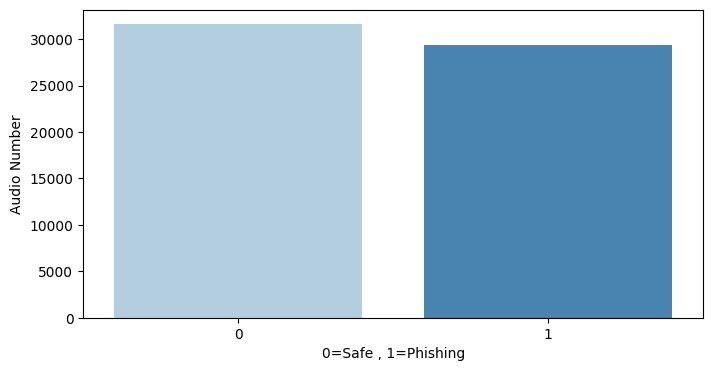

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=final_audio, x='label', palette='Blues')
plt.xlabel("0=Safe , 1=Phishing")
plt.ylabel("Audio Number")
plt.show()

In [ ]:
# final_audio.to_csv('final_audio_dataset.csv', index=False)

# Confirm export by displaying the first few rows
# print(final_audio.head())

In [ ]:
final_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61032 entries, 0 to 61031
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   61032 non-null  int64 
 1   text    61032 non-null  object
dtypes: int64(1), object(1)
memory usage: 953.8+ KB


## 3.6 Dataset Cleaning

**Clean the transcript**

* Removing Hyperlinks
* Lower Case
* Tokenization
* Removing Special Characters
* Removing stop words and punctuation
* Stemming

In [ ]:
import string
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def cleaned_data(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters except letters and numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Tokenize the cleaned text
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():  # Keep only alphanumeric tokens
            y.append(i)

    text = y[:]
    y.clear()

    # Remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
cleaned_data("Hello! Visit https://example.com for 50% OFF on your purchase!!! Don't miss out. Call us NOW at 123-456-7890 or email at sales@example.com.")

'hello visit exampl com 50 purchas miss call us 123 456 7890 email sale exampl com'

In [ ]:
final_audio['cleaned_text'] = final_audio['text'].apply(cleaned_data)

In [ ]:
final_audio.head()

,label,text,cleaned_text
0,0,"hi, how are you doing? i'm fine. how about you...",hi fine
1,0,i'm fine. how about yourself? i'm pretty good....,fine pretti good thank ask
2,0,i'm pretty good. thanks for asking. no problem...,pretti good thank ask problem
3,0,no problem. so how have you been? i've been gr...,problem great
4,0,i've been great. what about you? i've been goo...,great good school right


In [ ]:
#final_audio = final_audio[['label','cleaned_text']]

#final_audio.to_csv('modified_dataset99.csv', index=False)

#final_audio.head()

## 3.7 EDA

**Getting Cleaned audio file**

In [ ]:
audio1 = pd.read_csv('cleaned_audio.csv')

In [ ]:
audio1.sample(5)

,label,cleaned_text
55609,1,payment overdu avoid penalti updat payment inf...
16403,0,valu pleasur pain consid measur accord intens ...
3601,0,take power quit
39027,1,import account secur risk pleas confirm person...
16418,0,take shape long round arch path high two end a...


**Importing that cleaned email dataset**

In [ ]:
audio2 = pd.read_csv('cleaned_emails_final.csv')

In [ ]:
audio2.sample(5)

,label,cleaned_text
58745,1,front get smart wilmett ill kid youfeel escape...
53524,1,least disappoint pretti somewher bad companion...
88437,0,mon escapenumb jun escapenumb hassenescapenumb...
44509,0,tri path expand escapenumb escapenumb escapenu...
76074,0,brazo request ga volum septemb 25 2001 forecas...


**Merging Both files**

In [ ]:
audio = pd.concat([audio1, audio2], ignore_index=True)

In [ ]:
audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162017 entries, 0 to 162016
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   label         162017 non-null  int64 
 1   cleaned_text  161992 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


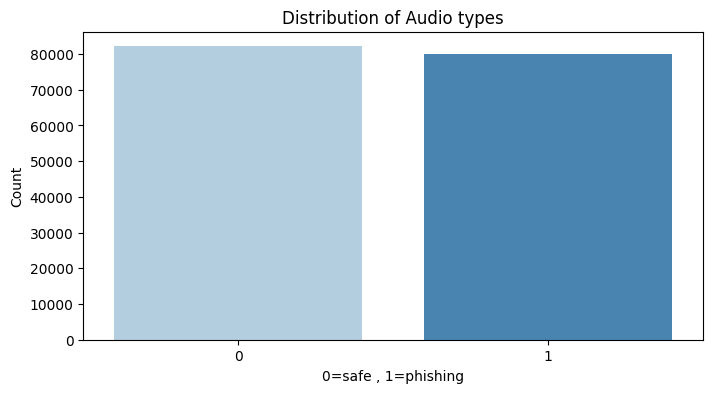

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=audio, x='label', palette='Blues')
plt.xlabel("0=safe , 1=phishing")
plt.ylabel("Count")
plt.title("Distribution of Audio types")
plt.show()

In [ ]:
audio.isnull().sum()

,0
label,0
cleaned_text,25


In [ ]:
audio = audio.dropna()
print(audio.isna().sum())

label           0
cleaned_text    0
dtype: int64


## 3.8 Feature Extraction

**Tokenization: Input IDs and Attention Mask**

Tokenization breaks down the text into smaller pieces called tokens (words or subwords) and assigns each token a unique ID from the model's vocabulary.

**Input IDs:**

*     A list of integers representing the tokenized text.
*     Essential because models can only process numerical data.

**Attention Mask:**

*     A binary mask indicating which tokens are real (1) and which are padding (0).
*     Necessary when sentences are padded to a fixed length. Padding ensures all inputs are the same size, but the     
      attention mask tells the model to focus only on actual content, not padding.

**Example:** For the sentence: "Hello, how are you?", after tokenization:

*     Input IDs: [31414, 6, 1300, 42, 47, 136, 0, 0, 0]
*     Attention Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0]

The model uses input IDs for understanding the content and the attention mask to ignore padding, ensuring efficient processing of variable-length inputs.

**Tokenization using roBERTa's tokenizer**

In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split  # Import this to fix the error

# Assuming audio DataFrame with 'text' and 'label' columns
train_df, val_df = train_test_split(audio, test_size=0.2, stratify=audio['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    save_total_limit=1,
    fp16=True,
    report_to="none",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the fine-tuned model and tokenizer
trainer.save_model('./roberta-audio-model')
tokenizer.save_pretrained('./roberta-audio-model')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/129593 [00:00<?, ? examples/s]

Map:   0%|          | 0/32399 [00:00<?, ? examples/s]

Step,Training Loss
500,0.265100
1000,0.153300
1500,0.118600
2000,0.094300
2500,0.087800
3000,0.094100
3500,0.073900
4000,0.071600
4500,0.054500
5000,0.040200


('./roberta-audio-model/tokenizer_config.json',
 './roberta-audio-model/special_tokens_map.json',
 './roberta-audio-model/vocab.json',
 './roberta-audio-model/merges.txt',
 './roberta-audio-model/added_tokens.json')

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


eval_results = trainer.evaluate()


predictions = trainer.predict(val_dataset)


logits = predictions.predictions
labels = predictions.label_ids


predicted_labels = logits.argmax(axis=-1)


accuracy = accuracy_score(labels, predicted_labels)


precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='binary')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9909
Precision: 0.9941
Recall: 0.9874
F1-Score: 0.9908


In [ ]:
# import joblib

# Save tokenizer and model using joblib
# joblib.dump(tokenizer, 'tokenizer.pkl')
# joblib.dump(model, 'roberta_model.pkl')

# Load tokenizer and model using joblib
# tokenizer = joblib.load('tokenizer.pkl')
# model = joblib.load('roberta_model.pkl')

## 3.9 Inference

**Importing trained model**

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the tokenizer and model from the Kaggle dataset directory
tokenizer = RobertaTokenizer.from_pretrained('roberta-audio-model')
model = RobertaForSequenceClassification.from_pretrained('roberta-audio-model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_prediction(input_text):
    inputs = tokenizer([input_text], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_label = predictions.item()
    result = "Phishing" if predicted_label == 1 else "Safe"
    return result

text_input = widgets.Text(
    value='',
    placeholder='Enter text for phishing detection...',
    description='Input:',
    disabled=False
)

output_label = widgets.Label(value="")

button = widgets.Button(description="Submit")

def on_button_click(b):
    input_text = text_input.value
    prediction_result = get_prediction(input_text)
    output_label.value = f"Predicted Label: {prediction_result}"

button.on_click(on_button_click)

display(text_input)
display(button)
display(output_label)

Text(value='', description='Input:', placeholder='Enter text for phishing detection...')

Button(description='Submit', style=ButtonStyle())

Label(value='')

## 3.10 Fine Tuning

**Adiding and cleaning more datasets**

**Dataset 1**

In [ ]:
odf1 = pd.read_csv("CEAS_08.csv")

odf1.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [ ]:
print(odf1.columns)

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls'], dtype='object')


In [ ]:
odf1 = odf1[['body', 'label']].rename(columns={'body': 'text', 'label': 'label'})

odf1 = odf1[['label', 'text']]

In [ ]:
odf1.sample(5)

,label,text
5657,0,"Also, the sa-blacklist inclusion policy is at:..."
2133,1,\nSize DOES matter - change your life today!\n...
12114,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
13852,0,\nLet's say I wanted to return the actual date...
35886,1,\nLove is the beginning of all the joy which n...


**Dataset 2**

In [ ]:
odf2 = pd.read_csv("Enron.csv")

odf2.head()

,subject,body,label
0,"hpl nom for may 25 , 2001",( see attached file : hplno 525 . xls )\n- hpl...,0
1,re : nom / actual vols for 24 th,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"enron actuals for march 30 - april 1 , 201","estimated actuals\nmarch 30 , 2001\nno flow\nm...",0
3,"hpl nom for may 30 , 2001",( see attached file : hplno 530 . xls )\n- hpl...,0
4,"hpl nom for june 1 , 2001",( see attached file : hplno 601 . xls )\n- hpl...,0


In [ ]:
odf2 = odf2[['body', 'label']].rename(columns={'body': 'text', 'label': 'label'})

odf2 = odf2[['label', 'text']]

In [ ]:
odf2.sample(5)

,label,text
24228,1,thinking of breathing new life into your busin...
24412,1,the best place to buy viagra online at the bes...
13146,0,my one year anniversary at enron is june lst ....
11277,0,"hey , look at this ! we will now terminate the..."
15298,1,our licensed gps check your case history in ti...


In [ ]:
odf3 = pd.read_csv("Ling.csv")

odf3.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [ ]:
odf3 = odf3[['body', 'label']].rename(columns={'body': 'text', 'label': 'label'})

odf3 = odf3[['label', 'text']]

In [ ]:
odf3.sample(5)

,label,text
689,1,/ / / / / / / / / / / / / / / / / / / / / / / ...
2412,0,6th international cognitive linguistics confer...
1768,0,"a theory of linguistic signs rudi keller , hei..."
2151,0,position announcement french lexicographer com...
2132,0,international association of forensic linguist...


In [ ]:
odf4 = pd.read_csv("SpamAssasin.csv")

odf4.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


In [ ]:
odf4 = odf4[['body', 'label']].rename(columns={'body': 'text', 'label': 'label'})

odf4 = odf4[['label', 'text']]

In [ ]:
odf4.sample(5)

,label,text
269,0,zzzz@spamassassin.taint.org (Justin Mason) wri...
3468,0,">>>>> ""E"" == Eugen Leitl writes: E> ... M..."
3741,0,On Monday 22 July 2002 07:00 CET John Rudd wro...
826,0,One of the most bizarre pages I've seen on the...
4074,0,"Hi all,\n\nI cannot to get this to run... I t..."


In [ ]:
odf5 = pd.read_csv("TREC_07.csv")

odf5.head()

,sender,receiver,date,subject,body,label,urls
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 21:00:48 +0300","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,1,0
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Sun, 08 Apr 2007 12:52:30 -0400",Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0,1
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,"Sun, 08 Apr 2007 17:12:19 +0000",authentic viagra,Mega authenticV I A G R A $ DISCOUNT priceC...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 17:15:47 -0100",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 19:19:07 +0200",or trembling; stomach cramps; trouble in sleep...,"\nsystem"" of the home. It will have the capab...",1,0


In [ ]:
odf5 = odf5[['body', 'label']].rename(columns={'body': 'text', 'label': 'label'})

odf5 = odf5[['label', 'text']]

In [ ]:
odf5.sample(5)

,label,text
9751,1,\n\nToo busy to go back to school?\n\n\n\n\n\n...
33264,1,"\n\n\n\nDear sirs,\nAegis Capital ..."
21946,0,Make sure your HP emails always go straight to...
53753,1,\n\n\n\nWhile we may have high ...
52569,1,\n[]\n\nEnters a into the column. If you are n...


In [ ]:
odf = pd.concat([odf1, odf2, odf3, odf4, odf5], ignore_index=True)


odf.to_csv('merged_dataset.csv', index=False)

In [ ]:
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131346 entries, 0 to 131345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   131346 non-null  int64 
 1   text    131345 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [ ]:
odf.isnull().sum()

,0
label,0
text,1


In [ ]:
odf = odf.dropna()
print(odf.isna().sum())

label    0
text     0
dtype: int64


In [ ]:
odf.duplicated().sum()

np.int64(0)

In [ ]:
odf.shape

(131345, 2)

In [ ]:
email_type_counts = odf['label'].value_counts()

In [ ]:
print(email_type_counts)

label
1    67392
0    63953
Name: count, dtype: int64


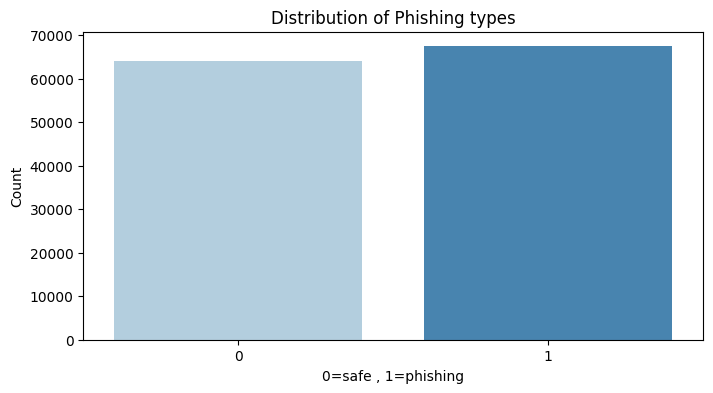

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=odf, x='label', palette='Blues')
plt.xlabel("0=safe , 1=phishing")
plt.ylabel("Count")
plt.title("Distribution of Phishing types")
plt.show()

In [ ]:
odf = pd.read_csv('odf_before_cleaning.csv')

odf.head()

,label,text
0,1,"Buck up, your troubles caused by small dimensi..."
1,1,\nUpgrade your sex and pleasures with these te...
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
3,0,Would anyone object to removing .so from this ...
4,1,\nWelcomeFastShippingCustomerSupport\nhttp://7...


In [ ]:
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131345 entries, 0 to 131344
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   131345 non-null  int64 
 1   text    131345 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


**Cleaning this**

In [ ]:
import time
from joblib import Parallel, delayed
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk

# Global NLTK resources
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def cleaned_data(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters except letters and numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Tokenize the cleaned text
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():  # Keep only alphanumeric tokens
            y.append(i)

    text = y[:]
    y.clear()

    # Remove stopwords and punctuation
    for i in text:
        if i not in stop_words and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

# Parallel processing function
def parallel_cleaned_data(df, func, num_cores=4):
    start_time = time.time()  # Start time
    result = Parallel(n_jobs=num_cores)(delayed(func)(text) for text in df['text'])
    end_time = time.time()  # End time

    print(f"Time taken: {end_time - start_time} seconds")
    return result

# Apply parallel processing
odf['cleaned_text'] = parallel_cleaned_data(odf, cleaned_data)

Time taken: 481.0746810436249 seconds


In [ ]:
odf.head()

,label,text,cleaned_text
0,1,"Buck up, your troubles caused by small dimensi...",buck troubl caus small dimens soon becom lover...
1,1,\nUpgrade your sex and pleasures with these te...,upgrad sex pleasur techniqu http www brightmad...
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,daili top 10 cnn com top video stori aug 1 200...
3,0,Would anyone object to removing .so from this ...,would anyon object remov list tld basic dead f...
4,1,\nWelcomeFastShippingCustomerSupport\nhttp://7...,welcomefastshippingcustomersupport http 7iwfna...


In [ ]:
#odf = odf[['label','cleaned_text']]

#odf.to_csv('1_3m_cleaned_mails.csv', index=False)

#odf.head()

In [ ]:
#odf.info()

In [ ]:
grp5 = pd.read_csv('1_3m_cleaned_mails.csv')

grp5.head()

,label,cleaned_text
0,1,buck troubl caus small dimens soon becom lover...
1,1,upgrad sex pleasur techniqu http www brightmad...
2,1,daili top 10 cnn com top video stori aug 1 200...
3,0,would anyon object remov list tld basic dead f...
4,1,welcomefastshippingcustomersupport http 7iwfna...


In [ ]:
grp5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131345 entries, 0 to 131344
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   label         131345 non-null  int64 
 1   cleaned_text  131326 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [ ]:
grp5.isnull().sum()

,0
label,0
cleaned_text,19


In [ ]:
grp5 = grp5.dropna()
print(grp5.isna().sum())

label           0
cleaned_text    0
dtype: int64


In [ ]:
grp5.duplicated().sum()

np.int64(2487)

In [ ]:
grp5 = grp5.drop_duplicates(keep='first')
grp5.duplicated().sum()

np.int64(0)

In [ ]:
email_type_counts = grp5['label'].value_counts()

In [ ]:
print(email_type_counts)

label
1    65371
0    63468
Name: count, dtype: int64


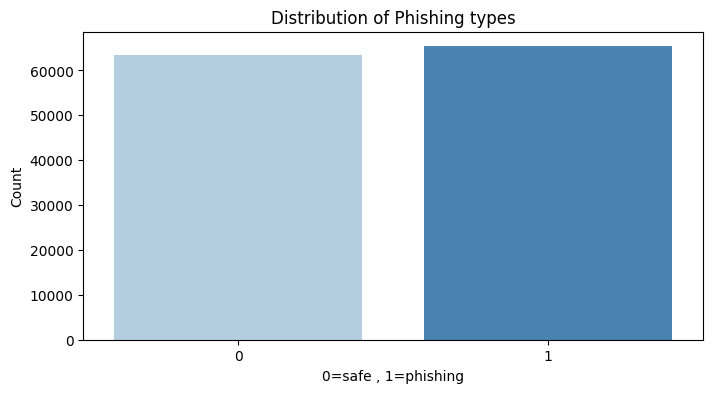

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=grp5, x='label', palette='Blues')
plt.xlabel("0=safe , 1=phishing")
plt.ylabel("Count")
plt.title("Distribution of Phishing types")
plt.show()

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


#Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(grp5, test_size=0.2, stratify=grp5['label'], random_state=42)

#Convert the DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

#Load the pre-trained RoBERTa model and tokenizer from your Kaggle dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-audio-model')
model = RobertaForSequenceClassification.from_pretrained('roberta-audio-model', num_labels=2)

#Tokenize the dataset using the tokenizer
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

#Define compute_metrics function to evaluate the model's performance
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Training arguments for fine-tuning with early stopping, learning rate decay, and increased epochs
training_args = TrainingArguments(
    output_dir='./results',               # Save results
    num_train_epochs=3,                   # Fine-tune for 3 epochs
    per_device_train_batch_size=64,       # Increased batch size
    per_device_eval_batch_size=64,        # Increased eval batch size
    warmup_steps=500,                     # Warm-up steps
    learning_rate=2e-5,                   # Fine-tuned learning rate
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./logs',                 # Directory for logs         # Evaluate at each epoch
    save_strategy="epoch",                # Save model at the end of each epoch to match eval strategy
    save_total_limit=1,                   # Keep only 1 checkpoint
    fp16=True,                            # Enable mixed precision
    report_to="none",                     # No reporting to third-party services
    lr_scheduler_type="linear",           # Learning rate scheduler (linear decay)
    load_best_model_at_end=True,          # Required for EarlyStoppingCallback
    metric_for_best_model="f1",           # Define the metric for the best model
)

#Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,      # Add metrics for accuracy and F1 score
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

# Fine-tune the model
trainer.train()

trainer.save_model('./fine-tuned-roberta')
tokenizer.save_pretrained('./fine-tuned-roberta')

Map:   0%|          | 0/103071 [00:00<?, ? examples/s]

Map:   0%|          | 0/25768 [00:00<?, ? examples/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

**Exporting Model**

## 3.11 Inference

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('/kaggle/input/roberta-fine_tuned_v2/pytorch/vesrion-2/1/kaggle/working/fine-tuned-roberta')
model = RobertaForSequenceClassification.from_pretrained('/kaggle/input/roberta-fine_tuned_v2/pytorch/vesrion-2/1/kaggle/working/fine-tuned-roberta')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_prediction(input_text):
    inputs = tokenizer([input_text], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_label = predictions.item()
    result = "Phishing" if predicted_label == 1 else "Safe"
    return result

text_input = widgets.Text(
    value='',
    placeholder='Enter text for phishing detection...',
    description='Input:',
    disabled=False
)

output_label = widgets.Label(value="")

button = widgets.Button(description="Submit")

def on_button_click(b):
    input_text = text_input.value
    prediction_result = get_prediction(input_text)
    output_label.value = f"Predicted Label: {prediction_result}"

button.on_click(on_button_click)

display(text_input)
display(button)
display(output_label)

## 3.12 using large models

**Combinig and cleaning all the datasets that we previously used**

In [ ]:
#merging both previously used dataset

adf = pd.concat([audio,grp5], ignore_index=True)

In [ ]:

adf.sample(5)

**Cleaning a bit beacuse some transcripts generated by synetic audio generator python code so it might repeat**

**Checking for duplicates**

In [ ]:
adf.duplicated().sum()

In [ ]:
adf = adf.drop_duplicates(keep='first')
adf.duplicated().sum()

In [ ]:
adf.shape

In [ ]:
adf.info()

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=adf, x='label', palette='Blues')
plt.xlabel("0=safe , 1=phishing")
plt.ylabel("Count")
plt.title("Distribution of Phishing types")
plt.show()

## 3.13 Model Training

In [ ]:
import torch
print(torch.cuda.is_available())

**Using RoBERTa modle for our use**

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import numpy as np
import gc
from datetime import datetime

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_roberta_base(adf, model_save_path='./roberta-base-phishing'):
    print("Starting full training preparation...")
    print(f"Total dataset size: {len(adf)}")

    # Split data
    train_df, val_df = train_test_split(adf, test_size=0.2, stratify=adf['label'], random_state=42)
    print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

    # Convert to datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    # Free memory
    del train_df, val_df
    gc.collect()
    torch.cuda.empty_cache()

    print("Loading RoBERTa-base model and tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=2,
    )

    # Enable gradient checkpointing
    model.gradient_checkpointing_enable()

    print("Tokenizing datasets...")
    def tokenize_function(examples):
        tokenized = tokenizer(
            examples['cleaned_text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors=None
        )
        tokenized['labels'] = examples['label']
        return tokenized

    # Process datasets with progress bars
    train_dataset = train_dataset.map(
        tokenize_function,
        batched=True,
        batch_size=1000,
        remove_columns=train_dataset.column_names,
        desc="Tokenizing training set"
    )

    val_dataset = val_dataset.map(
        tokenize_function,
        batched=True,
        batch_size=1000,
        remove_columns=val_dataset.column_names,
        desc="Tokenizing validation set"
    )

    # Set format for pytorch
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Calculate training steps
    batch_size = 32
    num_epochs = 2
    total_steps = len(train_dataset) * num_epochs // batch_size
    warmup_steps = total_steps // 10  # 10% of total steps

    print(f"Total training steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")

    # Training arguments optimized for full dataset
    training_args = TrainingArguments(
        output_dir=model_save_path,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=warmup_steps,
        weight_decay=0.01,
        learning_rate=2e-5,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
        report_to="none",
        gradient_accumulation_steps=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    print("Starting training...")
    start_time = datetime.now()
    trainer.train()
    training_time = datetime.now() - start_time

    print(f"\nTraining completed in: {training_time}")

    print("\nPerforming final evaluation...")
    final_metrics = trainer.evaluate()

    print("\nFinal Metrics:")
    print("-" * 50)
    print(f"Accuracy: {final_metrics['eval_accuracy']:.4f}")
    print(f"Precision: {final_metrics['eval_precision']:.4f}")
    print(f"Recall: {final_metrics['eval_recall']:.4f}")
    print(f"F1 Score: {final_metrics['eval_f1']:.4f}")

    # Save metrics to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    with open(f'training_metrics_{timestamp}.txt', 'w') as f:
        f.write(f"Training Time: {training_time}\n")
        f.write("\nFinal Metrics:\n")
        for key, value in final_metrics.items():
            f.write(f"{key}: {value:.4f}\n")

    print("\nSaving model and tokenizer...")
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    return trainer, model, tokenizer

def predict_phishing(texts, model, tokenizer, device='cuda'):
    model.eval()
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)

    predictions = []
    for prob in probabilities:
        predictions.append({
            'is_phishing': bool(prob[1] > 0.5),
            'confidence': prob[prob.argmax()].item(),
            'phishing_probability': prob[1].item()
        })
    return predictions

# Main execution
if __name__ == "__main__":
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

    print("Starting RoBERTa-base training...")
    trainer, model, tokenizer = train_roberta_base(adf)

    # Test on example texts
    test_texts = [
        "We never ask for your credit card number. If you want to do purchase and urgently need money than you can call on toll free number behind the card",
        "Your account has been locked. Please click here to verify your identity.",
        "Thank you for your recent purchase. Here is your receipt."
    ]

    print("\nTesting model on example texts:")
    predictions = predict_phishing(test_texts, model, tokenizer)

    for text, pred in zip(test_texts, predictions):
        print("\nText:", text[:100], "...")
        print(f"Phishing Probability: {pred['phishing_probability']:.3f}")
        print(f"Confidence: {pred['confidence']:.3f}")
        print(f"Classification: {'Phishing' if pred['is_phishing'] else 'Legitimate'}")

In [ ]:
# !zip -r roberta_final.zip /kaggle/working/

## 3.14 Inference

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('/kaggle/input/roberta-fine_tuned_v3/pytorch/version-3/1/kaggle/working/roberta-base-phishing')
model = RobertaForSequenceClassification.from_pretrained('/kaggle/input/roberta-fine_tuned_v3/pytorch/version-3/1/kaggle/working/roberta-base-phishing')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_prediction(input_text):
    inputs = tokenizer([input_text], return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_label = predictions.item()
    result = "Phishing" if predicted_label == 1 else "Safe"
    return result

text_input = widgets.Text(
    value='',
    placeholder='Enter text for phishing detection...',
    description='Input:',
    disabled=False
)

output_label = widgets.Label(value="")

button = widgets.Button(description="Submit")

def on_button_click(b):
    input_text = text_input.value
    prediction_result = get_prediction(input_text)
    output_label.value = f"Predicted Label: {prediction_result}"

button.on_click(on_button_click)

display(text_input)
display(button)
display(output_label)

# Section 4 - Url Phishing Detection

## 4 Introduction